# PACKAGE IMPORT

In [84]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
import scipy.stats as stats
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

import getpass  # to get the password without showing the input
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

········


# DATAFRAME SET UP

In [85]:
query = '''SELECT * from credit_card_classification.credit_card_data;'''

df = pd.read_sql_query(query, engine)
df

,customer_number,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,17996,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,167.50,136,65,71
17972,17997,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984,940,943
17973,17998,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918,767,1170
17974,17999,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022.25,626,983,865


# DATA CLEANING

## HEADERS STANDARDIZATION

In [86]:
#let's first standardize columns
df.columns = [column.lower().replace(' ', '_') for column in df.columns]
df.columns

Index(['customer_number', 'offer_accepted', 'reward', 'mailer_type',
       'income_level', 'bank_accounts_open', 'overdraft_protection',
       'credit_rating', 'credit_cards_held', 'homes_owned', 'household_size',
       'own_your_home', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance'],
      dtype='object')

In [87]:
#now let's define a function to remove special characters from column names (except "_")
def alphanum(df):
    alpha=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    numeric= ['0','1','2','3','4','5','6','7','8','9']
    keep=['_']
    cols = df.columns
    new_col_names=[]
    for col in cols:
        new_col = ''
        for arg in col:
            if (arg in numeric) or (arg in alpha) or (arg in keep):
                new_col += arg
        new_col_names.append(new_col)
    df.columns = new_col_names
    return df
                

In [88]:
df = alphanum(df)
df.head()

,customer_number,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982


# EDA

## DESCRIBE, NULL

In [89]:
df.describe()

,customer_number,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance
count,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,8999.727192,1.255730,1.903427,1.203549,3.499110,940.515562,910.450656,999.392190,1042.033600
std,5196.958865,0.472405,0.797086,0.427446,1.114476,350.297837,620.077060,457.402268,553.452599
min,1.000000,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000
25%,4498.750000,1.000000,1.000000,1.000000,3.000000,787.500000,392.750000,663.000000,633.000000
50%,9000.500000,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.500000
75%,13501.250000,1.000000,2.000000,1.000000,4.000000,1153.250000,1521.000000,1342.000000,1463.000000
max,18000.000000,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000


In [90]:
df.isna().sum()

customer_number         0
offer_accepted          0
reward                  0
mailer_type             0
income_level            0
bank_accounts_open      0
overdraft_protection    0
credit_rating           0
credit_cards_held       0
homes_owned             0
household_size          0
own_your_home           0
average_balance         0
q1_balance              0
q2_balance              0
q3_balance              0
dtype: int64

In [91]:
df.info(verbose=True, null_counts=True) #no null values to deal with

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17976 entries, 0 to 17975
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_number       17976 non-null  int64  
 1   offer_accepted        17976 non-null  object 
 2   reward                17976 non-null  object 
 3   mailer_type           17976 non-null  object 
 4   income_level          17976 non-null  object 
 5   bank_accounts_open    17976 non-null  int64  
 6   overdraft_protection  17976 non-null  object 
 7   credit_rating         17976 non-null  object 
 8   credit_cards_held     17976 non-null  int64  
 9   homes_owned           17976 non-null  int64  
 10  household_size        17976 non-null  int64  
 11  own_your_home         17976 non-null  object 
 12  average_balance       17976 non-null  float64
 13  q1_balance            17976 non-null  int64  
 14  q2_balance            17976 non-null  int64  
 15  q3_balance         

In [92]:
cat = df.select_dtypes('object')
cat

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes
3,No,Air Miles,Letter,Medium,No,High,No
4,No,Air Miles,Letter,Medium,No,Medium,Yes
...,...,...,...,...,...,...,...
17971,No,Cash Back,Letter,High,No,Low,Yes
17972,No,Cash Back,Letter,High,No,Low,Yes
17973,No,Cash Back,Letter,High,No,Low,No
17974,No,Cash Back,Letter,Medium,No,Medium,Yes


In [93]:
for col in df.select_dtypes('object'):
    print(df[col].value_counts(), '\n') #no reattribution to operate on uniques

No     16955
Yes     1021
Name: offer_accepted, dtype: int64 

Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64 

Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64 

Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64 

No     15300
Yes     2676
Name: overdraft_protection, dtype: int64 

High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64 

Yes    11636
No      6340
Name: own_your_home, dtype: int64 



## CORRELATION MATRIX

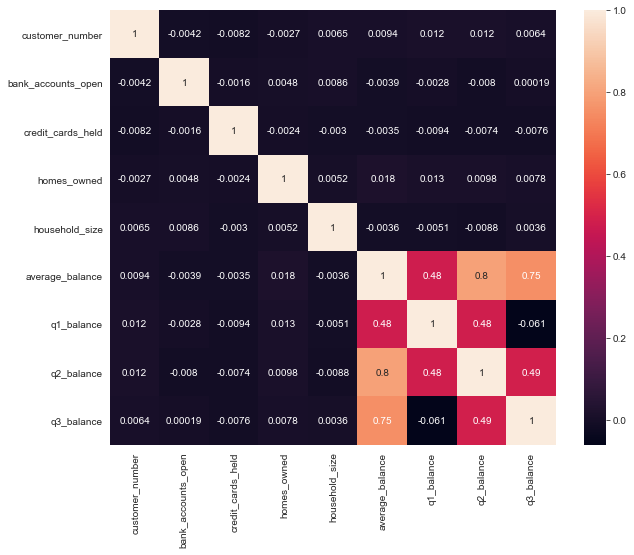

In [94]:
corr_matrix=df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

## CHI SQUARE TEST

## DISTRIBUTION PLOTS ON RAW DATA

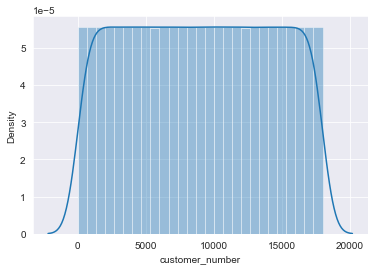

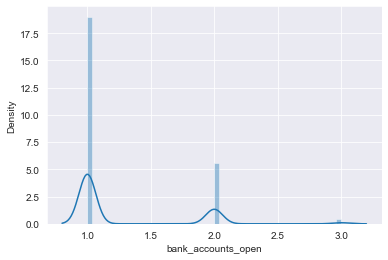

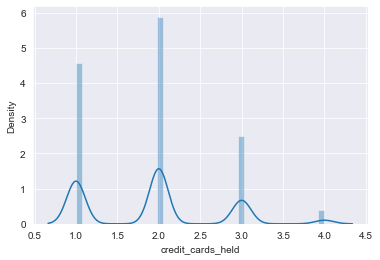

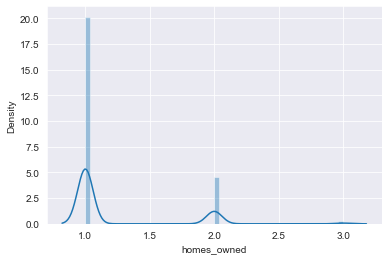

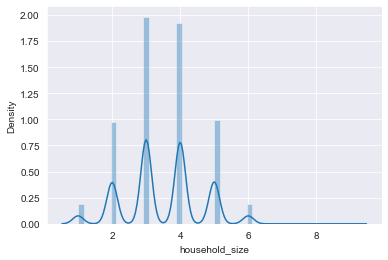

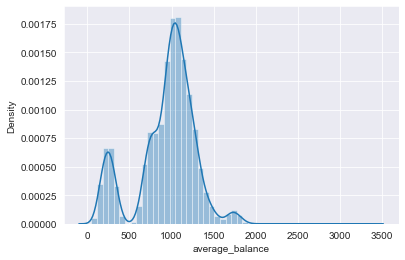

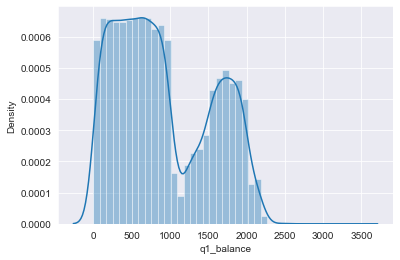

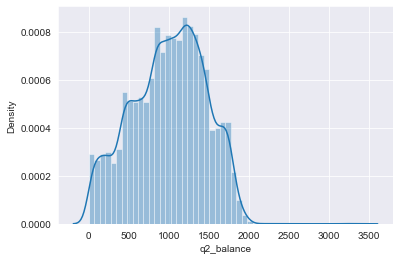

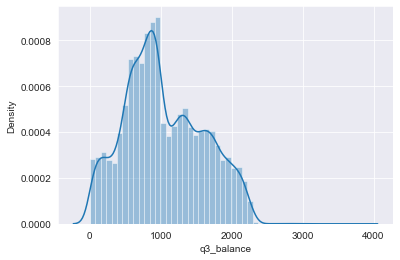

In [95]:
for col in df.select_dtypes(np.number):
    sns.distplot(df[col])
    plt.show()

In [96]:
# customer_number is the id, unique, so I passed it as the index
df = df.set_index('customer_number')
df.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance
customer_number,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982


In [97]:
dfd = df.copy()

# FEATURE ENGINEERING

## REMOVING OUTLIERS

In [98]:
#let's deal with the outliers as logistic regression is not robust to outliers
def remove_outliers(dfd, threshold=1.5, in_columns=dfd.select_dtypes(np.number).columns, skip_columns=[]):
    for column in in_columns:
        if column not in skip_columns:
            upper = np.percentile(dfd[column],75)
            lower = np.percentile(dfd[column],25)
            iqr = upper - lower
            upper_limit = upper + (threshold * iqr)
            lower_limit = lower - (threshold * iqr)
            dfd = dfd[(df[column]>lower_limit) & (dfd[column]<upper_limit)]
    return dfd

In [99]:
dfo=remove_outliers(dfd,threshold=1.5,skip_columns=['bank_accounts_open','homes_owned','credit_cards_held','household_size']) #skipping the two columns because they are categorical
dfo

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance
customer_number,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982
6,No,Air Miles,Letter,Medium,1,No,High,3,1,4,No,1114.75,1847,1365,750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,No,Air Miles,Postcard,Medium,1,No,Low,2,1,2,Yes,985.25,295,917,1608
17997,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850.50,984,940,943
17998,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087.25,918,767,1170


## DISTRIBUTION PLOTS AFTER OUTLIERS REMOVED

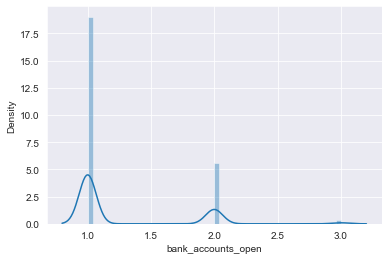

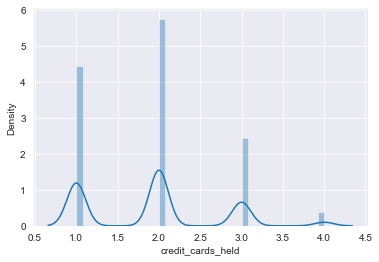

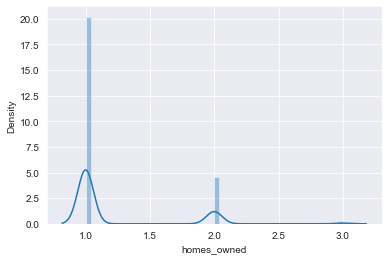

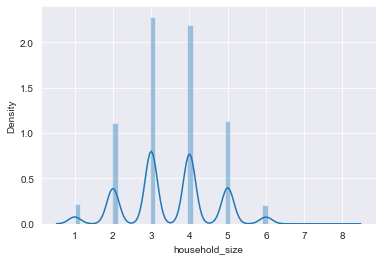

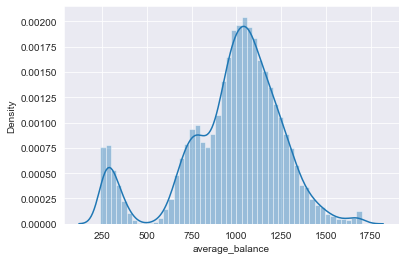

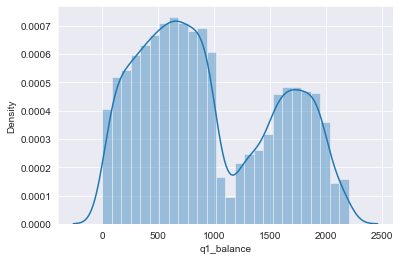

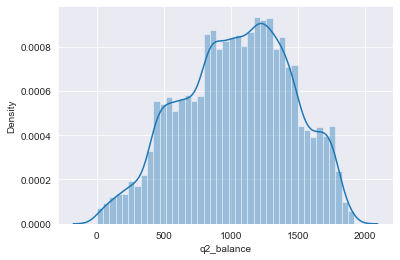

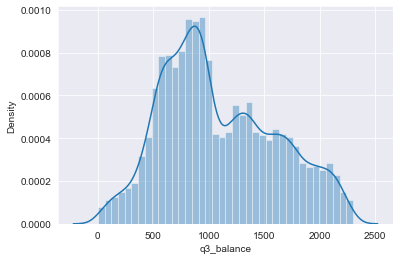

In [100]:
for col in dfo.select_dtypes(np.number):
    sns.distplot(dfo[col])
    plt.show()

## ENCODING CATEGORICAL VARIABLES

In [101]:
#encoding categorical variables
dfe = pd.get_dummies(dfo, columns=['reward', 'mailer_type', 'income_level', 'overdraft_protection', 'credit_rating', 'own_your_home'])
dfe

,offer_accepted,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,,
1,No,1,2,1,4,1160.75,1669,877,1095,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
3,No,2,2,1,2,276.50,367,352,145,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1
4,No,2,1,1,4,1219.00,1578,1760,1119,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0
5,No,1,2,1,6,1211.00,2140,1357,982,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1
6,No,1,3,1,4,1114.75,1847,1365,750,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,No,1,2,1,2,985.25,295,917,1608,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1
17997,No,1,3,1,3,850.50,984,940,943,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
17998,No,1,2,1,4,1087.25,918,767,1170,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0


## LOGISTIC REGRESSION MODEL

### WITHOUT SAMPLING

In [102]:
y = dfe['offer_accepted']
X = dfe.drop('offer_accepted', axis=1)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [105]:
classification.score(X_test, y_test) #without dealing with data imbalance, accuracy is 94.68%

0.9461747807680677

In [106]:
predictionsLR = classification.predict(X_test)
confusion_matrix(y_test, predictionsLR)

array([[3129,    0],
       [ 178,    0]], dtype=int64)

<AxesSubplot:>

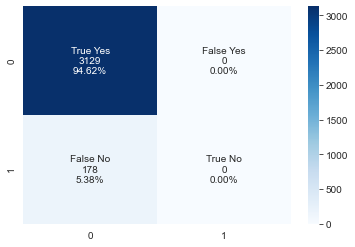

In [107]:
cf_matrixLR = confusion_matrix(y_test, predictionsLR)
group_namesLR = ['True Yes', 'False Yes', 
               'False No', 'True No']

group_countsLR = ["{0:0.0f}".format(value) for value in cf_matrixLR.flatten()]
group_percentagesLR = ["{0:.2%}".format(value) for value in cf_matrixLR.flatten()/np.sum(cf_matrixLR)]
labelsLR = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_namesLR,group_countsLR,group_percentagesLR)]
labelsLR = np.asarray(labelsLR).reshape(2,2)
sns.heatmap(cf_matrixLR, annot=labelsLR, fmt='', cmap='Blues')

### SAMPLING TO 8K

In [108]:
#I decide to upsample Yes and downsample No --> sample = 8 000
No8 = dfe[dfe['offer_accepted'] == 'No'].sample(8000, replace=True)
Yes8 = dfe[dfe['offer_accepted'] == 'Yes'].sample(8000, replace=True)
sampled8 = pd.concat([Yes8, No8]).sample(frac=1)
sampled8

,offer_accepted,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,,
478,Yes,2,2,1,3,1054.75,1364,1360,446,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1
17501,Yes,2,1,1,2,1126.00,1943,1071,469,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0
15760,No,2,1,1,2,746.25,799,784,664,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1
13876,Yes,1,1,1,3,805.25,570,584,1141,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1
9252,Yes,1,1,1,4,707.00,557,512,859,1,0,0,1,0,0,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11237,No,1,1,1,4,1053.25,491,726,1375,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1
4660,Yes,1,2,1,2,1072.25,1563,1356,1179,0,0,1,1,0,0,0,1,1,0,0,0,1,0,1
1608,No,1,2,1,4,833.25,177,634,889,1,0,0,0,1,1,0,0,1,0,1,0,0,0,1


In [109]:
sampled8.offer_accepted.value_counts()
#checking if sampling was correcly done

No     8000
Yes    8000
Name: offer_accepted, dtype: int64

In [110]:
Xs8 = sampled8.drop('offer_accepted', axis=1)
ys8 = sampled8['offer_accepted']

In [111]:
Xs8 = pd.get_dummies(Xs8)
Xs8

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,
478,2,2,1,3,1054.75,1364,1360,446,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1
17501,2,1,1,2,1126.00,1943,1071,469,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0
15760,2,1,1,2,746.25,799,784,664,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1
13876,1,1,1,3,805.25,570,584,1141,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1
9252,1,1,1,4,707.00,557,512,859,1,0,0,1,0,0,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11237,1,1,1,4,1053.25,491,726,1375,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1
4660,1,2,1,2,1072.25,1563,1356,1179,0,0,1,1,0,0,0,1,1,0,0,0,1,0,1
1608,1,2,1,4,833.25,177,634,889,1,0,0,0,1,1,0,0,1,0,1,0,0,0,1


In [112]:
Xs8_train, Xs8_test, ys8_train, ys8_test = train_test_split(Xs8, ys8, test_size=0.2, random_state=42)

In [113]:
classification8 = LogisticRegression(random_state=42, max_iter=10000)
classification8.fit(Xs8_train, ys8_train)

LogisticRegression(max_iter=10000, random_state=42)

In [114]:
classification8.score(Xs8_test, ys8_test) #accuracy after balancing data is 69.1%

0.69625

In [115]:
predictionsLR8 = classification8.predict(Xs8_test)
confusion_matrix(ys8_test, predictionsLR8)

array([[1059,  504],
       [ 468, 1169]], dtype=int64)

<AxesSubplot:>

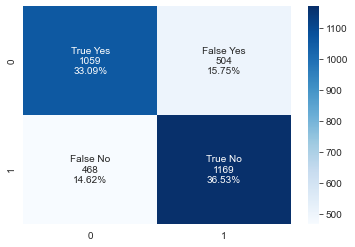

In [116]:
cf_matrixLR8 = confusion_matrix(ys8_test, predictionsLR8)
group_namesLR8 = ['True Yes', 'False Yes', 
               'False No', 'True No']

group_countsLR8 = ["{0:0.0f}".format(value) for value in cf_matrixLR8.flatten()]
group_percentagesLR8 = ["{0:.2%}".format(value) for value in cf_matrixLR8.flatten()/np.sum(cf_matrixLR8)]
labelsLR8 = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_namesLR8,group_countsLR8,group_percentagesLR8)]
labelsLR8 = np.asarray(labelsLR8).reshape(2,2)
sns.heatmap(cf_matrixLR8, annot=labelsLR8, fmt='', cmap='Blues')

In [117]:
print('Accuracy of logistic regression with 8k sampling on training set: {:.2f}'
     .format(classification8.score(Xs8_train, ys8_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(classification8.score(Xs8_test, ys8_test)))

Accuracy of logistic regression with 8k sampling on training set: 0.69
Accuracy of K-NN classifier on test set: 0.70


In [118]:
print(metrics.classification_report(ys8_test, predictionsLR8))

              precision    recall  f1-score   support

          No       0.69      0.68      0.69      1563
         Yes       0.70      0.71      0.71      1637

    accuracy                           0.70      3200
   macro avg       0.70      0.70      0.70      3200
weighted avg       0.70      0.70      0.70      3200



### SAMPLING TO 4K

In [119]:
#I decide to upsample Yes and downsample No --> sample = 4 000
No4 = dfe[dfe['offer_accepted'] == 'No'].sample(4000, replace=True)
Yes4 = dfe[dfe['offer_accepted'] == 'Yes'].sample(4000, replace=True)
sampled4 = pd.concat([Yes4, No4]).sample(frac=1)
sampled4

,offer_accepted,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,,
4122,Yes,1,1,1,2,1314.50,134,1309,1713,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1
918,Yes,1,1,1,3,1052.50,1953,1156,806,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1
13517,Yes,2,2,1,5,244.25,229,250,258,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1
15482,No,1,2,2,3,1697.50,1632,1649,1862,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0
8767,No,1,2,1,6,1066.25,585,1140,924,0,0,1,1,0,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,No,1,2,1,4,1157.50,1965,1168,1192,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1
2629,Yes,1,3,1,4,948.50,103,879,1679,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0
16017,Yes,1,3,1,4,1131.50,718,966,1277,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1


In [120]:
Xs4 = sampled4.drop('offer_accepted', axis=1)
ys4 = sampled4['offer_accepted']

In [121]:
Xs4 = pd.get_dummies(Xs4)
Xs4

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,
4122,1,1,1,2,1314.50,134,1309,1713,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1
918,1,1,1,3,1052.50,1953,1156,806,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1
13517,2,2,1,5,244.25,229,250,258,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1
15482,1,2,2,3,1697.50,1632,1649,1862,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0
8767,1,2,1,6,1066.25,585,1140,924,0,0,1,1,0,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,1,2,1,4,1157.50,1965,1168,1192,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1
2629,1,3,1,4,948.50,103,879,1679,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0
16017,1,3,1,4,1131.50,718,966,1277,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1


In [122]:
Xs4_train, Xs4_test, ys4_train, ys4_test = train_test_split(Xs4, ys4, test_size=0.2, random_state=42)

In [123]:
classification4 = LogisticRegression(random_state=42, max_iter=10000)
classification4.fit(Xs4_train, ys4_train)

LogisticRegression(max_iter=10000, random_state=42)

In [124]:
classification4.score(Xs4_test, ys4_test) #accuracy after balancing data is 69.2%

0.675625

In [125]:
predictionsLR4 = classification4.predict(Xs4_test)
confusion_matrix(ys4_test, predictionsLR4)

array([[517, 262],
       [257, 564]], dtype=int64)

<AxesSubplot:>

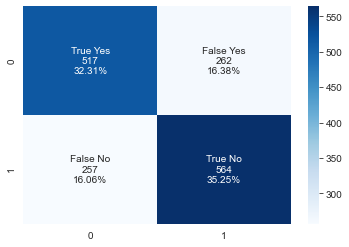

In [126]:
cf_matrixLR4 = confusion_matrix(ys4_test, predictionsLR4)
group_namesLR4 = ['True Yes', 'False Yes', 
               'False No', 'True No']

group_countsLR4 = ["{0:0.0f}".format(value) for value in cf_matrixLR4.flatten()]
group_percentagesLR4 = ["{0:.2%}".format(value) for value in cf_matrixLR4.flatten()/np.sum(cf_matrixLR4)]
labelsLR4 = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_namesLR4,group_countsLR4,group_percentagesLR4)]
labelsLR4 = np.asarray(labelsLR4).reshape(2,2)
sns.heatmap(cf_matrixLR4, annot=labelsLR4, fmt='', cmap='Blues')

### DOWNSAMPLING TO MINORITY CLASS 1K

In [127]:
#I decide to downsample Yes --> sample = 1 021 #count of yes
No1 = dfe[dfe['offer_accepted'] == 'No'].sample(1021, replace=True)
Yes1 = dfe[dfe['offer_accepted'] == 'Yes']
sampled1 = pd.concat([Yes1, No1]).sample(frac=1)
sampled1

,offer_accepted,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,,
16975,Yes,1,2,1,6,825.50,794,900,640,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1
3596,No,1,1,1,3,244.25,373,176,29,0,0,1,1,0,0,1,0,1,0,0,0,1,0,1
9133,Yes,1,2,1,5,915.75,164,496,1936,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1
16652,No,1,2,1,4,1153.50,1921,1287,935,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1
13806,No,1,1,1,4,308.25,418,412,210,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17715,Yes,2,4,1,3,1177.75,1949,1437,906,1,0,0,0,1,1,0,0,1,0,0,1,0,1,0
6367,Yes,2,1,1,5,317.50,426,55,400,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0
6448,Yes,1,3,1,1,716.75,555,926,637,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0


In [128]:
Xs1 = sampled1.drop('offer_accepted', axis=1)
ys1 = sampled1['offer_accepted']

In [129]:
Xs1 = pd.get_dummies(Xs1)
Xs1

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,
16975,1,2,1,6,825.50,794,900,640,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1
3596,1,1,1,3,244.25,373,176,29,0,0,1,1,0,0,1,0,1,0,0,0,1,0,1
9133,1,2,1,5,915.75,164,496,1936,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1
16652,1,2,1,4,1153.50,1921,1287,935,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1
13806,1,1,1,4,308.25,418,412,210,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17715,2,4,1,3,1177.75,1949,1437,906,1,0,0,0,1,1,0,0,1,0,0,1,0,1,0
6367,2,1,1,5,317.50,426,55,400,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0
6448,1,3,1,1,716.75,555,926,637,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0


In [130]:
Xs1_train, Xs1_test, ys1_train, ys1_test = train_test_split(Xs1, ys1, test_size=0.2, random_state=42)

In [131]:
classification1 = LogisticRegression(random_state=42, max_iter=10000)
classification1.fit(Xs1_train, ys1_train)

LogisticRegression(max_iter=10000, random_state=42)

In [132]:
classification1.score(Xs1_test, ys1_test) #accuracy after balancing data is 70.1%

0.670076726342711

In [133]:
predictionsLR1 = classification1.predict(Xs1_test)
confusion_matrix(ys1_test, predictionsLR1)

array([[132,  59],
       [ 70, 130]], dtype=int64)

<AxesSubplot:>

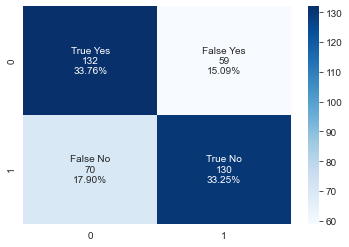

In [134]:
cf_matrixLR1 = confusion_matrix(ys1_test, predictionsLR1)
group_namesLR1 = ['True Yes', 'False Yes', 
               'False No', 'True No']

group_countsLR1 = ["{0:0.0f}".format(value) for value in cf_matrixLR1.flatten()]
group_percentagesLR1 = ["{0:.2%}".format(value) for value in cf_matrixLR1.flatten()/np.sum(cf_matrixLR1)]
labelsLR1 = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_namesLR1,group_countsLR1,group_percentagesLR1)]
labelsLR1 = np.asarray(labelsLR1).reshape(2,2)
sns.heatmap(cf_matrixLR1, annot=labelsLR1, fmt='', cmap='Blues')

### SMOTE

In [135]:
#now, let's try another sampling method to see if we can improve the model #SMOTE
smote = SMOTE()

XSM = dfe.drop('offer_accepted', axis=1)
ySM = dfe['offer_accepted']

In [136]:
#first, let's encode categoricals
Xsmote = pd.get_dummies(XSM)
Xsmote

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,
1,1,2,1,4,1160.75,1669,877,1095,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0
3,2,2,1,2,276.50,367,352,145,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1
4,2,1,1,4,1219.00,1578,1760,1119,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0
5,1,2,1,6,1211.00,2140,1357,982,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1
6,1,3,1,4,1114.75,1847,1365,750,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,1,2,1,2,985.25,295,917,1608,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1
17997,1,3,1,3,850.50,984,940,943,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1
17998,1,2,1,4,1087.25,918,767,1170,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0


In [137]:
X_sm, y_sm = smote.fit_resample(Xsmote, ySM)
y_sm.value_counts()

No     15601
Yes    15601
Name: offer_accepted, dtype: int64

In [138]:
Xsmote_train, Xsmote_test, ySM_train, ySM_test = train_test_split(Xsmote, ySM, test_size=0.2, random_state=42)

In [139]:
classificationSMOTE = LogisticRegression(random_state=42, max_iter=10000)
classificationSMOTE.fit(Xsmote_train, ySM_train)

LogisticRegression(max_iter=10000, random_state=42)

In [140]:
classificationSMOTE.score(Xsmote_test, ySM_test)

0.9461747807680677

In [141]:
predictionsLRS = classificationSMOTE.predict(Xsmote_test)
confusion_matrix(ySM_test, predictionsLRS)

array([[3129,    0],
       [ 178,    0]], dtype=int64)

<AxesSubplot:>

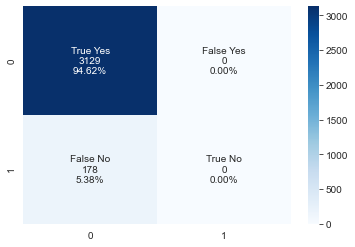

In [142]:
cf_matrixLRS = confusion_matrix(ySM_test, predictionsLRS)
group_namesLRS = ['True Yes', 'False Yes', 
               'False No', 'True No']

group_countsLRS = ["{0:0.0f}".format(value) for value in cf_matrixLRS.flatten()]
group_percentagesLRS = ["{0:.2%}".format(value) for value in cf_matrixLRS.flatten()/np.sum(cf_matrixLRS)]
labelsLRS = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_namesLRS,group_countsLRS,group_percentagesLRS)]
labelsLRS = np.asarray(labelsLRS).reshape(2,2)
sns.heatmap(cf_matrixLRS, annot=labelsLRS, fmt='', cmap='Blues')

### ACCURACIES SUMMARY

In [143]:
#summary of classification scores with sampling method
classification1.score(Xs1_test, ys1_test) #downsampled to count(Yes) --> 1021

0.670076726342711

In [144]:
classification8.score(Xs8_test, ys8_test) #sampled to 8k


0.69625

In [145]:
classification4.score(Xs4_test, ys4_test) #sampled to 4k

0.675625

In [146]:
classification.score(X_test, y_test) #no sampling

0.9461747807680677

In [147]:
classificationSMOTE.score(Xsmote_test, ySM_test)

0.9461747807680677

I go with the classification8 model (sampled to 8k)

In [148]:
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(classification8.score(Xs8_train, ys8_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(classification8.score(Xs8_test, ys8_test)))

Accuracy of Logistic regression classifier on training set: 0.69
Accuracy of Logistic regression classifier on test set: 0.70


In [149]:
print(metrics.classification_report(ys8_test, predictionsLR8))

              precision    recall  f1-score   support

          No       0.69      0.68      0.69      1563
         Yes       0.70      0.71      0.71      1637

    accuracy                           0.70      3200
   macro avg       0.70      0.70      0.70      3200
weighted avg       0.70      0.70      0.70      3200



### ROC CURVE

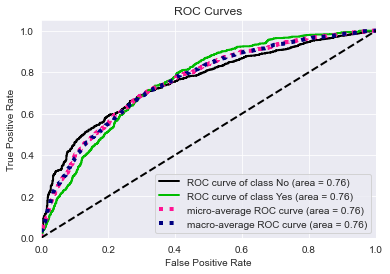

In [150]:
predicted_probas = classification8.predict_proba(Xs8_test)
skplt.metrics.plot_roc(ys8_test, predicted_probas)
plt.show()

## KNN CLASSIFIER MODEL

In [151]:
#testing the KNN classifier model
yK = dfe['offer_accepted']
XK = dfe.drop(['offer_accepted'],axis=1)

### CHECKING DISTRIBUTION

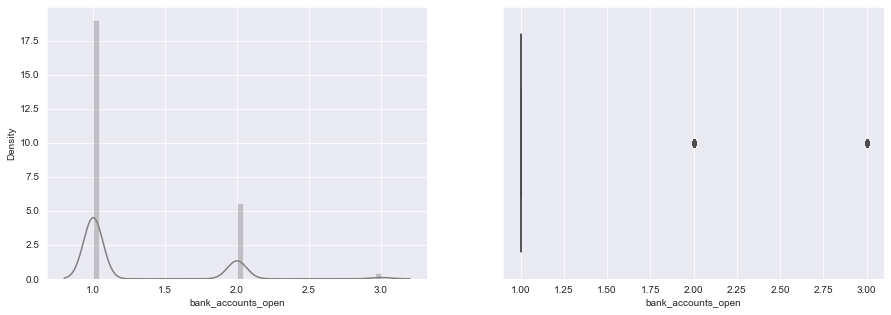

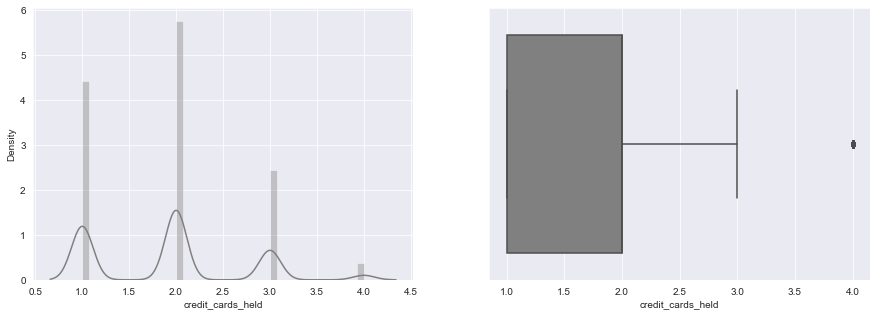

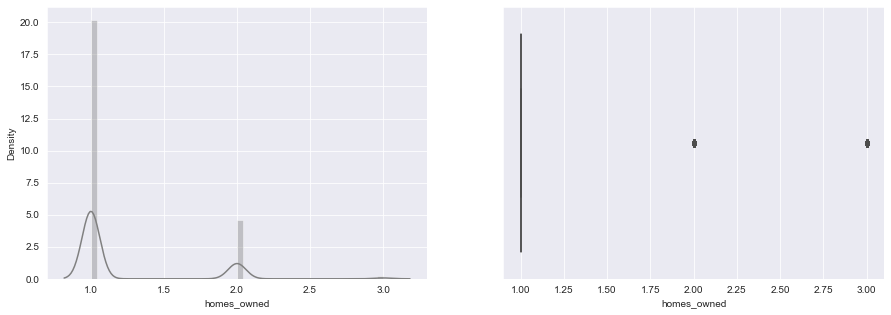

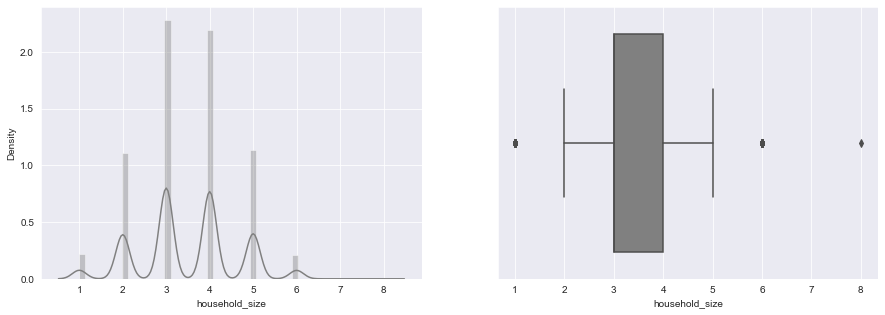

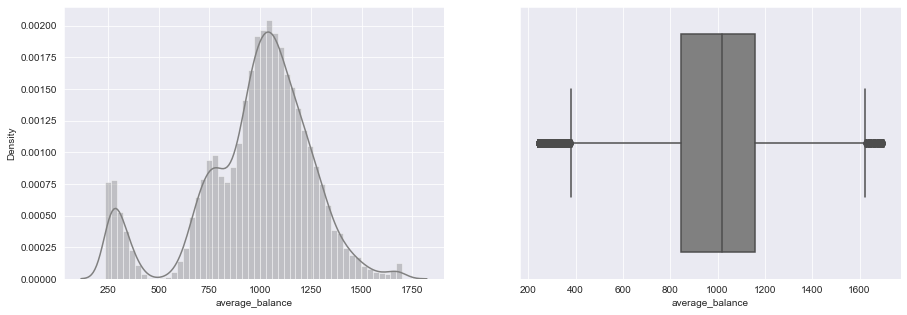

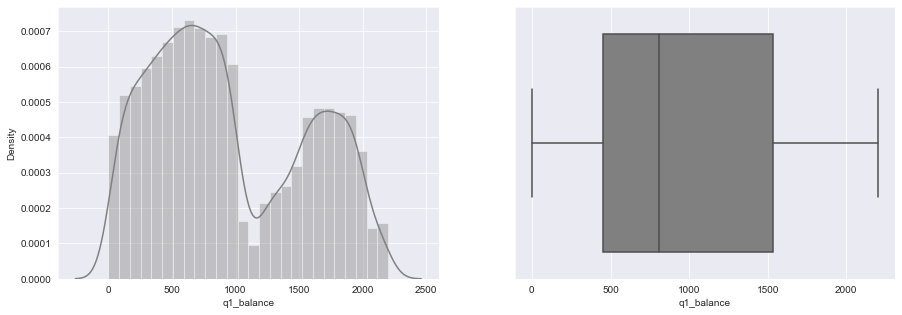

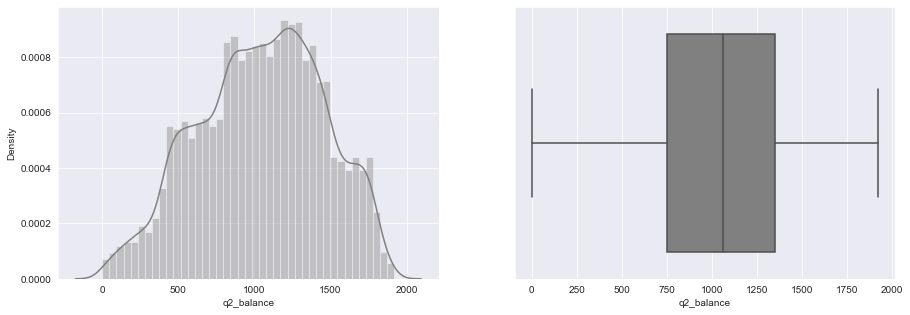

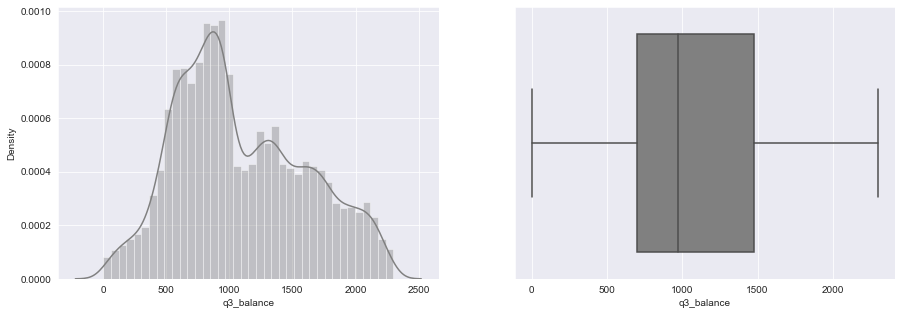

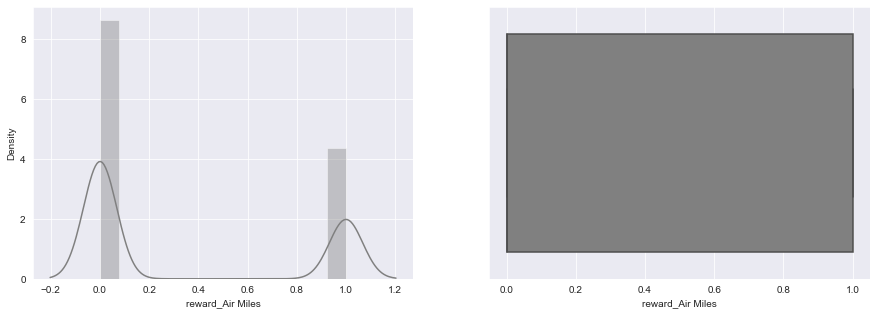

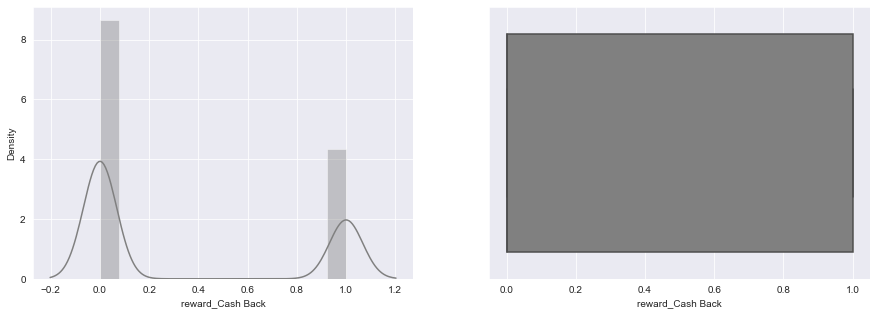

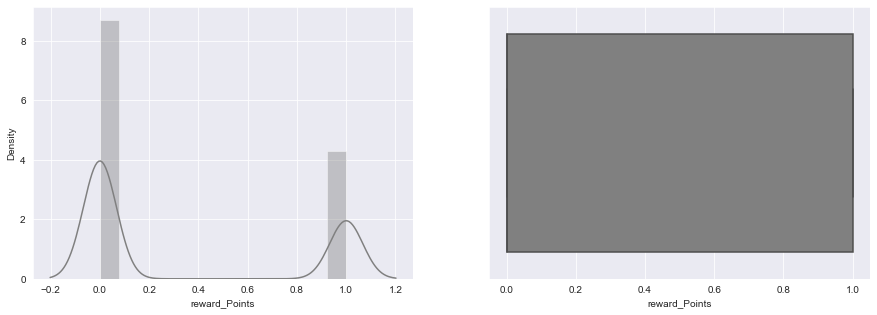

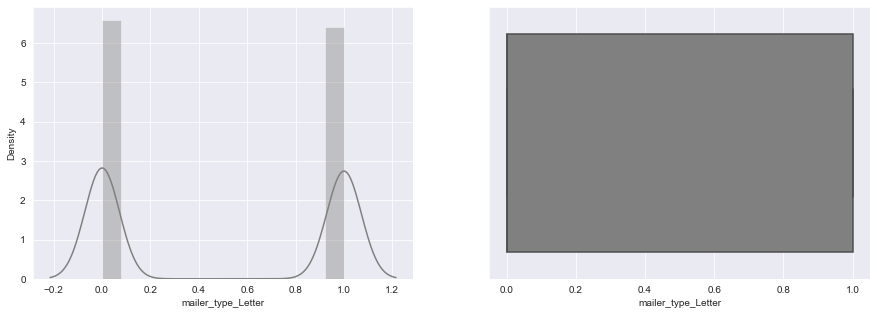

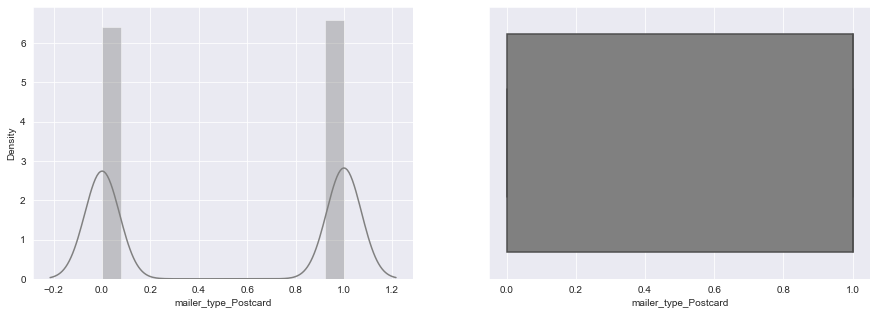

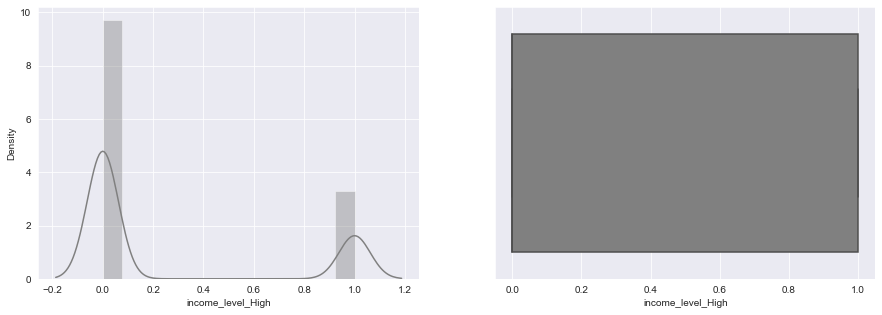

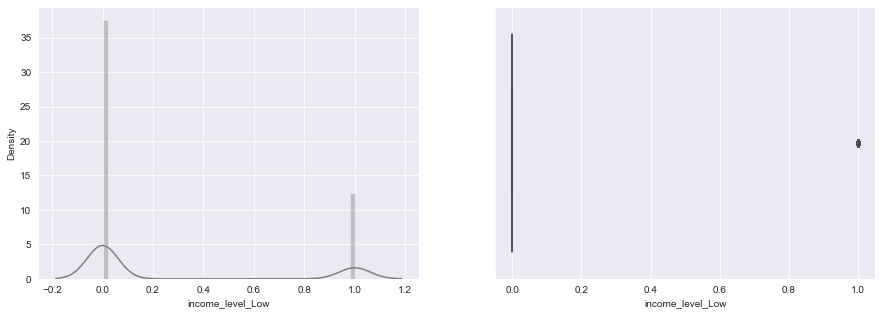

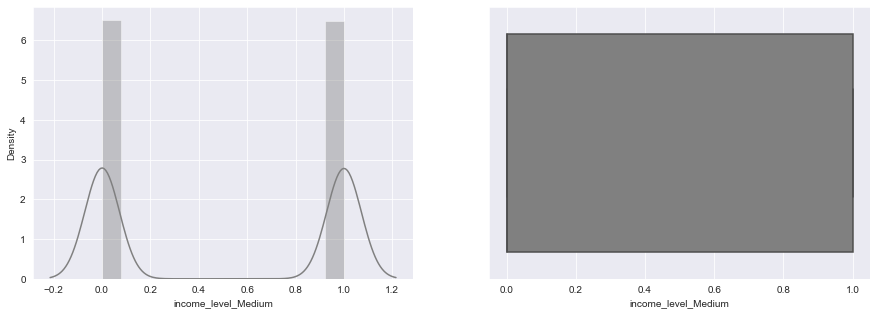

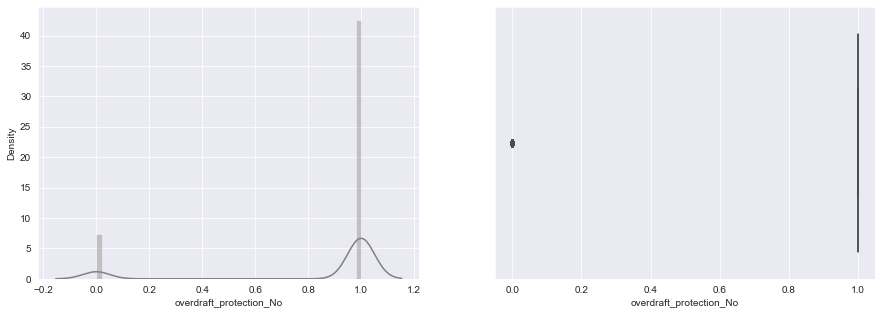

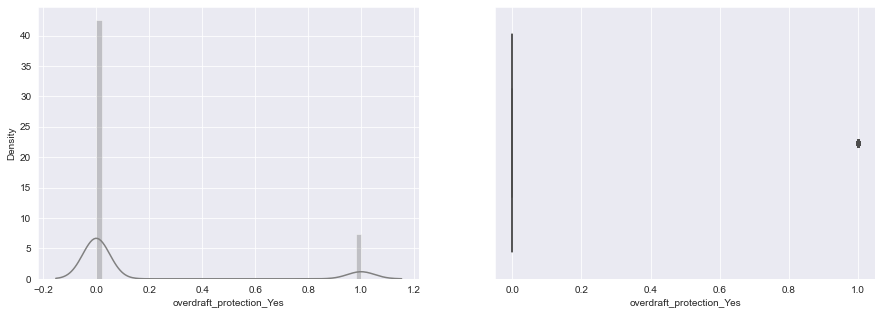

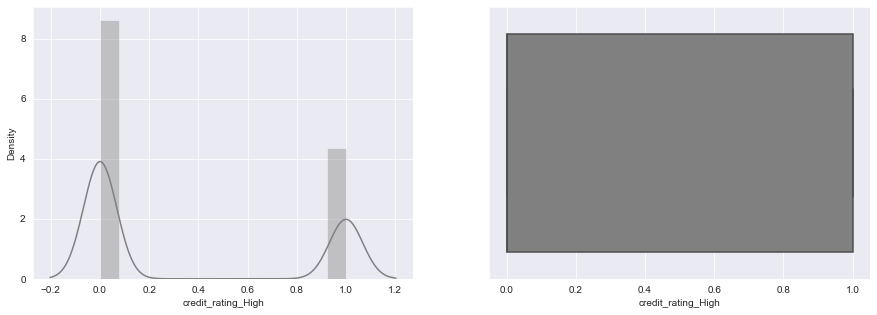

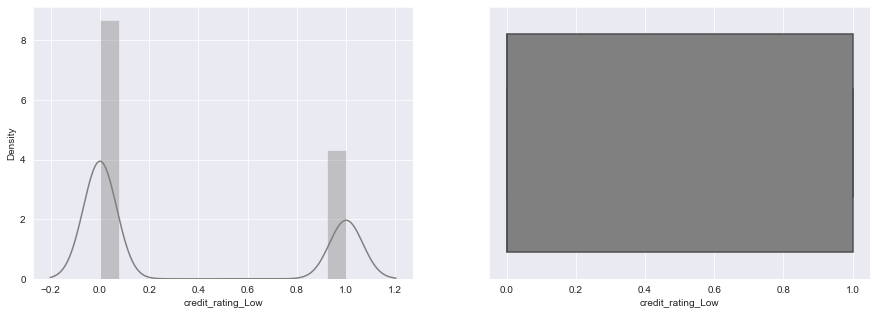

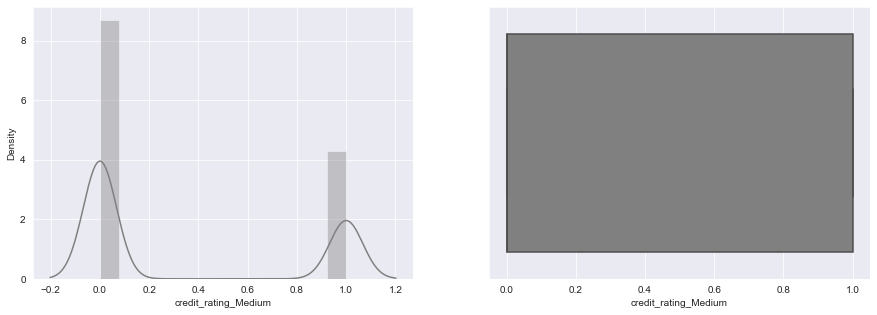

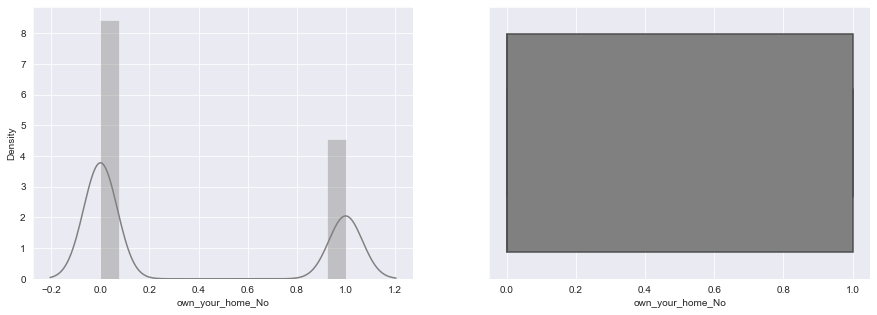

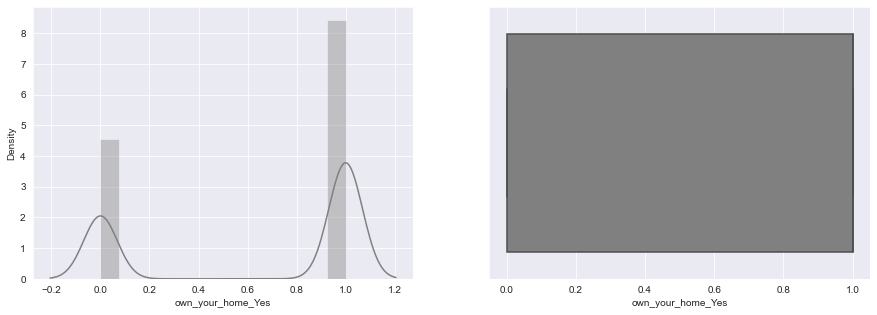

In [152]:
num = dfe.select_dtypes('number')
for c in num.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.set_style("darkgrid")
    sns.distplot(num[c], ax=axes[0],  color = 'gray')
    sns.boxplot(num[c], ax=axes[1],  color = 'gray')
    plt.show()


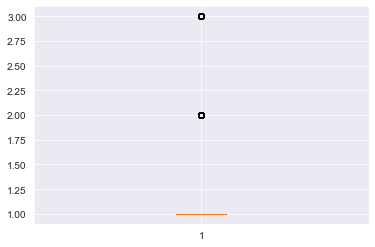

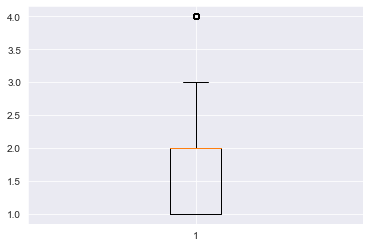

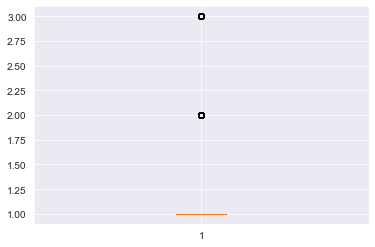

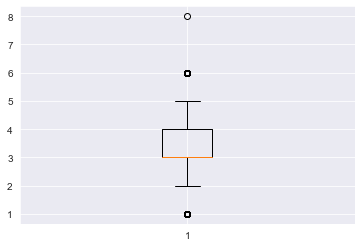

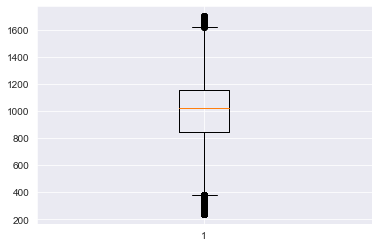

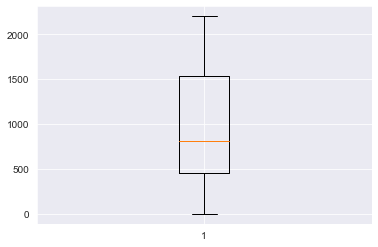

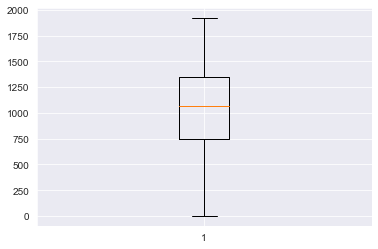

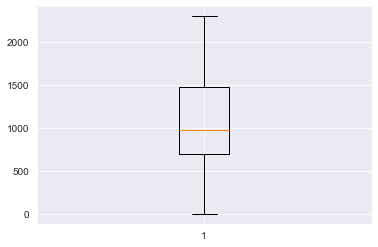

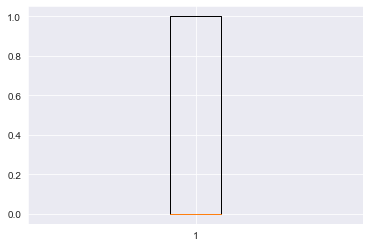

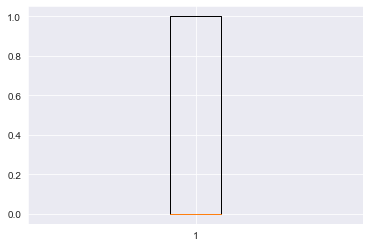

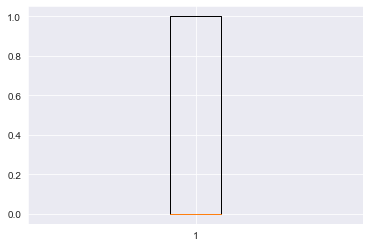

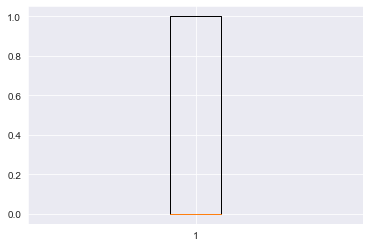

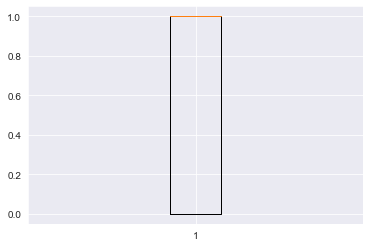

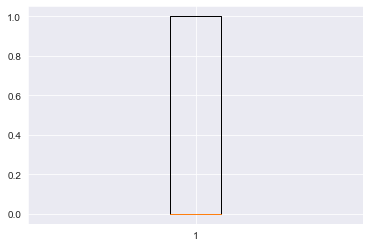

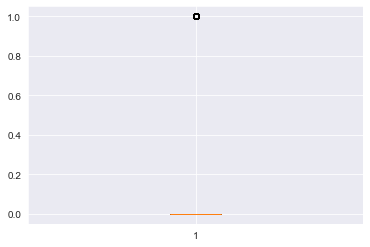

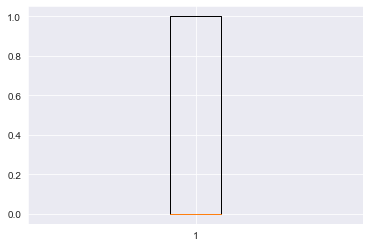

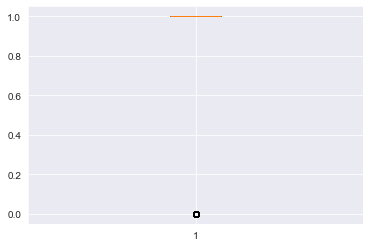

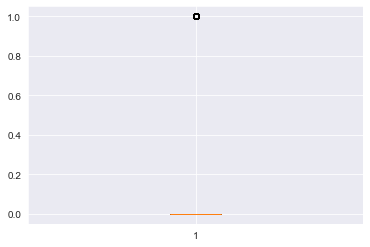

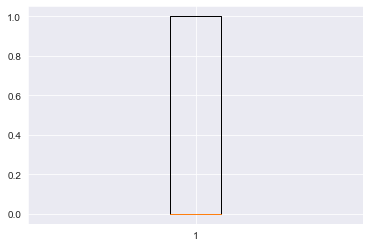

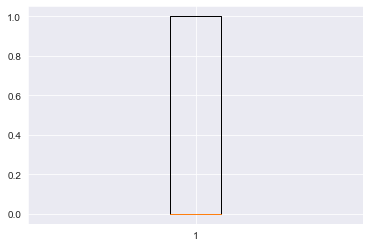

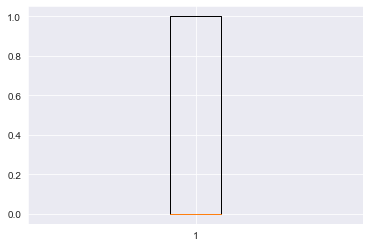

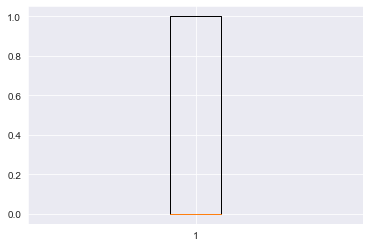

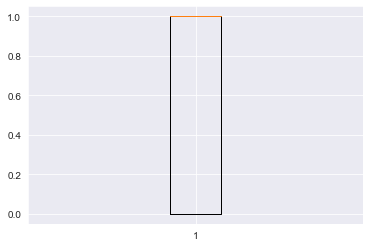

In [153]:
for column in dfe.select_dtypes(np.number).columns:
    plt.boxplot(dfe[column])
    plt.show()

In [154]:
numericalsKNN = Xs8.select_dtypes(np.number)
numericalsKNN

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
customer_number,,,,,,,,,,,,,,,,,,,,,,,
478,2,2,1,3,1054.75,1364,1360,446,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1
17501,2,1,1,2,1126.00,1943,1071,469,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0
15760,2,1,1,2,746.25,799,784,664,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1
13876,1,1,1,3,805.25,570,584,1141,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1
9252,1,1,1,4,707.00,557,512,859,1,0,0,1,0,0,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11237,1,1,1,4,1053.25,491,726,1375,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1
4660,1,2,1,2,1072.25,1563,1356,1179,0,0,1,1,0,0,0,1,1,0,0,0,1,0,1
1608,1,2,1,4,833.25,177,634,889,1,0,0,0,1,1,0,0,1,0,1,0,0,0,1


### NORMALIZING NUM COLUMNS

In [155]:
transformer = StandardScaler().fit(numericalsKNN)
x_standardized = transformer.transform(numericalsKNN)

In [156]:
categoricalsKNN = Xs8.select_dtypes(exclude=np.number)

### ENDODING CAT COLUMNS

In [157]:
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(categoricalsKNN)
encoded = encoder.transform(categoricalsKNN).toarray()

### TRAIN TEST SPLIT

In [158]:
Xs8 = np.concatenate((x_standardized, encoded), axis=1)
Xs8_train, Xs8_test, ys8_train, ys8_test = train_test_split(Xs8, ys8, test_size=0.2, random_state=100)

### FINDING BEST K

In [159]:
KNNscores = []
for i in range(2,13):
    KNNmodel = model = KNeighborsClassifier(n_neighbors=i)
    KNNmodel.fit(Xs8_train, ys8_train)
    KNNscores.append(KNNmodel.score(Xs8_test, ys8_test))


Text(0, 0.5, 'Accuracy')

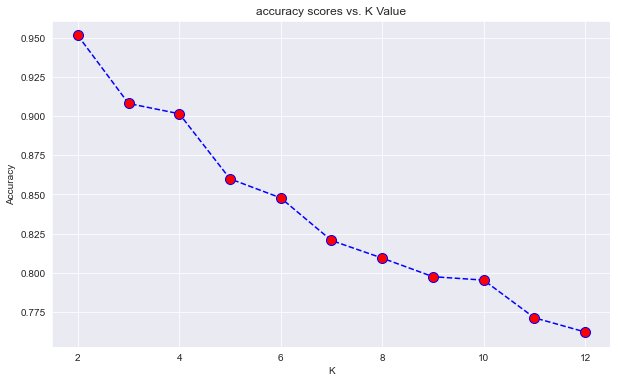

In [160]:
plt.figure(figsize=(10,6))
plt.plot(range(2,13),KNNscores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('accuracy scores vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy') 
#I will choose 4 as the KNN since accuracy is dropping a lot for k>4

In [161]:
classification8

LogisticRegression(max_iter=10000, random_state=42)

### PREDICTING

In [162]:
predictionsKNN = classification8.predict(Xs8_test)
confusion_matrix(ys8_test, predictionsKNN)

array([[1006,  608],
       [ 405, 1181]], dtype=int64)

<AxesSubplot:>

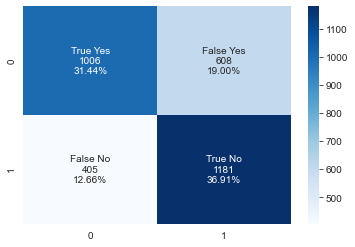

In [163]:
cf_matrixKNN = confusion_matrix(ys8_test, predictionsKNN)
group_namesKNN = ['True Yes', 'False Yes', 
               'False No', 'True No']

group_countsKNN = ["{0:0.0f}".format(value) for value in cf_matrixKNN.flatten()]
group_percentagesKNN = ["{0:.2%}".format(value) for value in cf_matrixKNN.flatten()/np.sum(cf_matrixKNN)]
labelsKNN = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_namesKNN,group_countsKNN,group_percentagesKNN)]
labelsKNN = np.asarray(labelsKNN).reshape(2,2)
sns.heatmap(cf_matrixKNN, annot=labelsKNN, fmt='', cmap='Blues')

In [164]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(KNNmodel.score(Xs8_train, ys8_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(KNNmodel.score(Xs8_test, ys8_test)))

Accuracy of K-NN classifier on training set: 0.81
Accuracy of K-NN classifier on test set: 0.76


In [165]:
print(metrics.classification_report(ys8_test, predictionsKNN))

              precision    recall  f1-score   support

          No       0.71      0.62      0.67      1614
         Yes       0.66      0.74      0.70      1586

    accuracy                           0.68      3200
   macro avg       0.69      0.68      0.68      3200
weighted avg       0.69      0.68      0.68      3200



# CONCLUSION

In this project, here is below a summary of what has been undertaken:
- Logistic regression model with different sampling techniques
    - Equally sample to 8k
    - Equally sample to 4K
    - Downsampling to minority class
    - Using SMOTE
- KNN classifier model with different K values
What I can now assume after comparing the different logistic regression models and the KNN classifier model is that my KNN classifier model seems to be less efficient looking at precision and recall (macro average of 0.68 vs macro average of 0.7 for logistic regression
